In [1]:
import numpy as np
import pandas as pd
import torch
from skorch import NeuralNetBinaryClassifier
from matplotlib import pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

np.random.seed(42)
plt.rcParams["figure.dpi"] = 150


In [2]:
df = pd.read_csv("./normalized_nybnb.csv").astype(np.float32)
X, y = df.drop(columns=["High Review Score"]), df["High Review Score"]
X, y = X.values, y.values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=y,
)

n_features = X_train.shape[1]

In [3]:
class LinearBatchNormReLuBlock(torch.nn.Module):
    def __init__(self, in_feature, out_feature):
        super(LinearBatchNormReLuBlock, self).__init__()
        self.linear = torch.nn.Linear(in_features=in_feature, out_features=out_feature)
        self.bn = torch.nn.BatchNorm1d(out_feature)
        self.relu = torch.nn.LeakyReLU()

    def forward(self, input):
        y = self.linear(input)
        y = self.bn(y)
        y = self.relu(y)
        return y

net = torch.nn.Sequential(
    LinearBatchNormReLuBlock(n_features, n_features * 2),
    LinearBatchNormReLuBlock(n_features * 2, n_features * 4),
    LinearBatchNormReLuBlock(n_features * 4, n_features * 2),
    LinearBatchNormReLuBlock(n_features * 2, n_features),
    torch.nn.Linear(n_features, 1),
)

ann = NeuralNetBinaryClassifier(
    net,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=5,
    batch_size=256,
    device="cuda",
    verbose=0,
)

In [4]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM with Linear kernel": SVC(kernel="linear"),
    "SVM with RBF kernel": SVC(kernel="rbf"),
    "SVM with Polynomial kernel": SVC(kernel="poly"),
    "SVM with Sigmoid kernel": SVC(kernel="sigmoid"),
    "ANN": ann,
}

for name, cls in classifiers.items():
    cls.fit(X_train, y_train)


In [5]:
def plot_roc_KFold(classifier: ClassifierMixin, K: 5, classifier_name=None) -> None:
    # ref https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    cv = StratifiedKFold(n_splits=K)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"Receiver operating characteristic for\n{classifier_name}",
    )
    ax.legend(loc="lower right")
    plt.show()


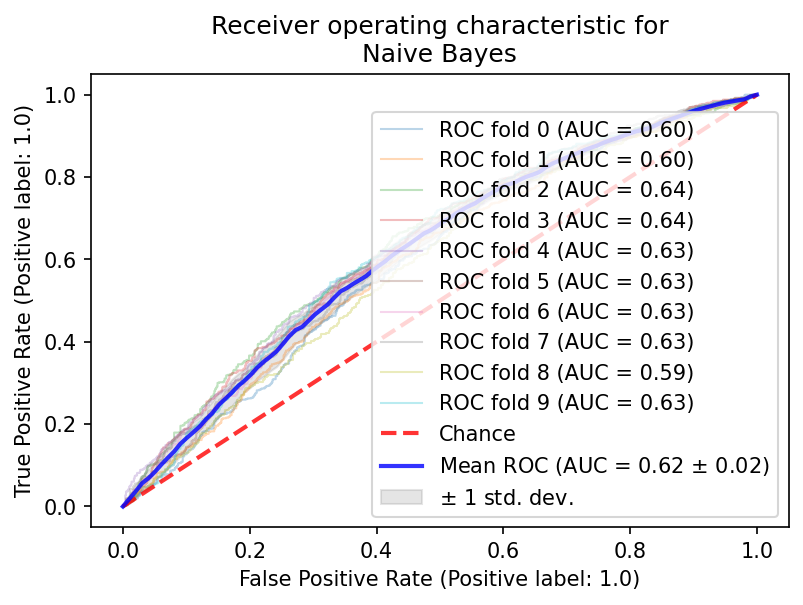

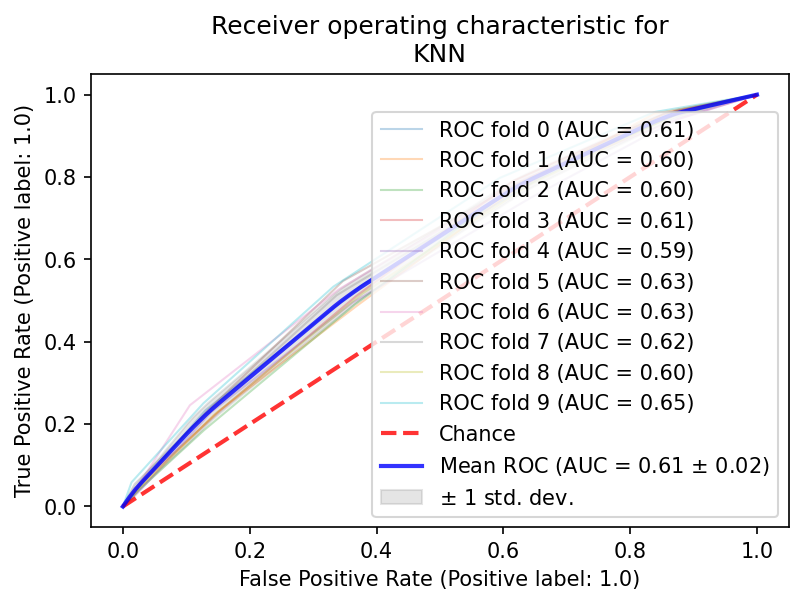

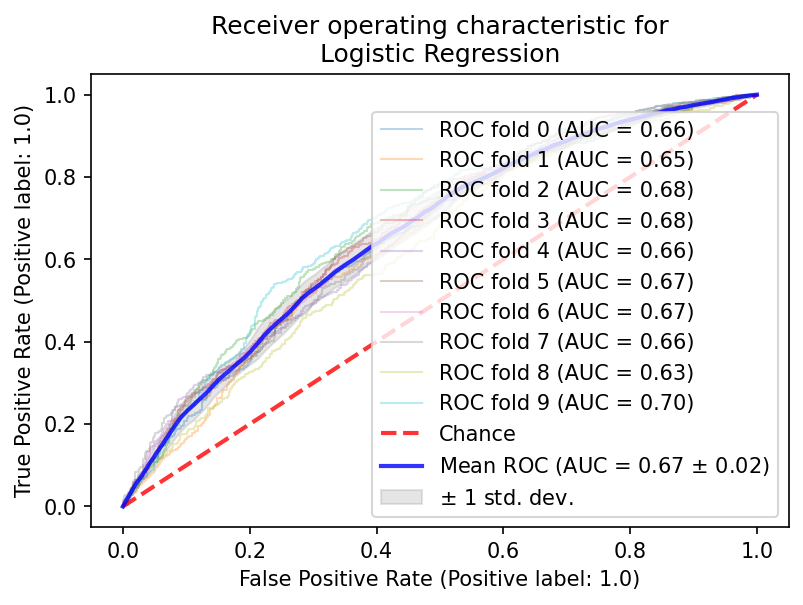

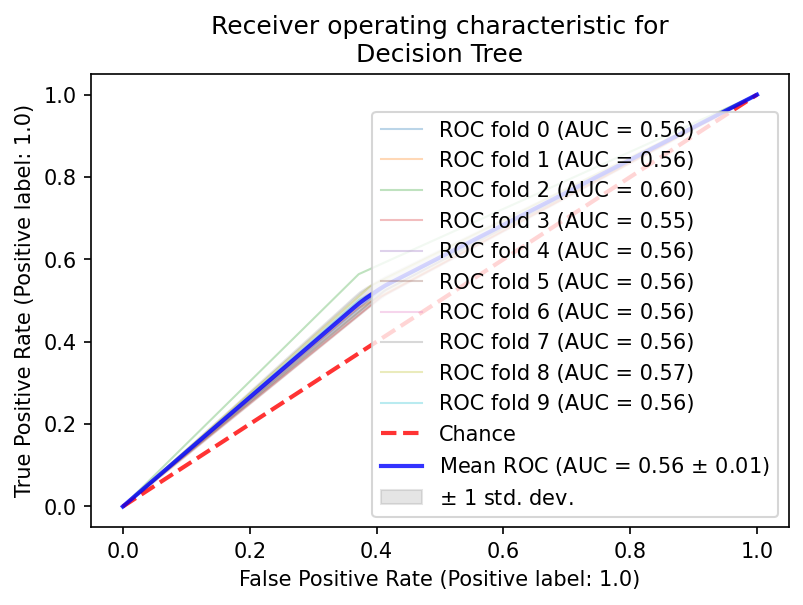

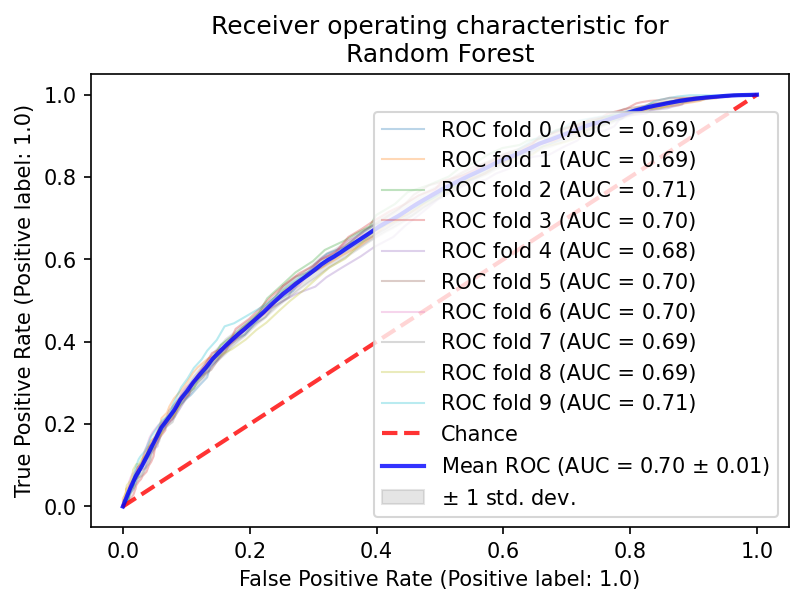

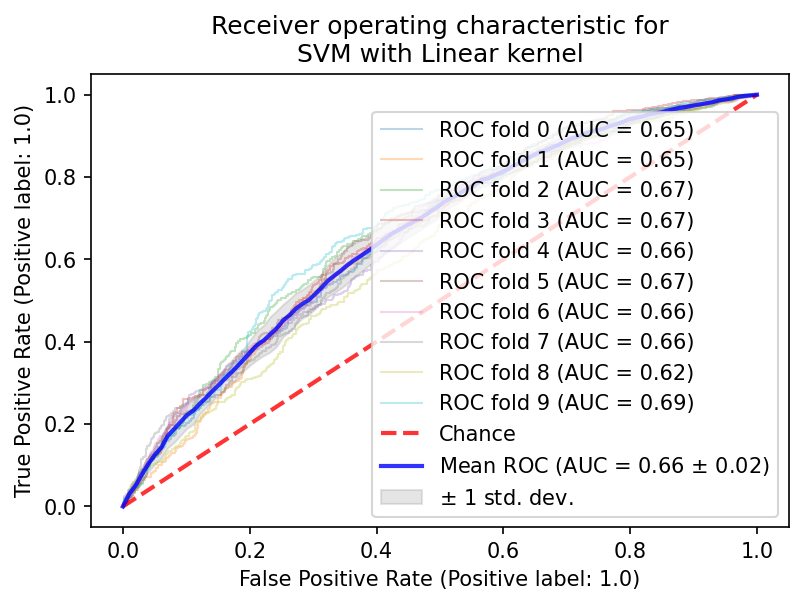

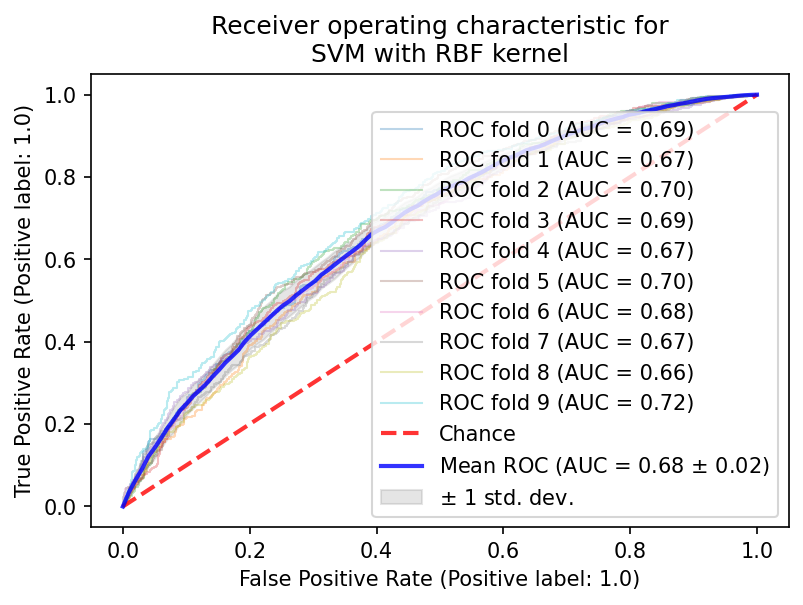

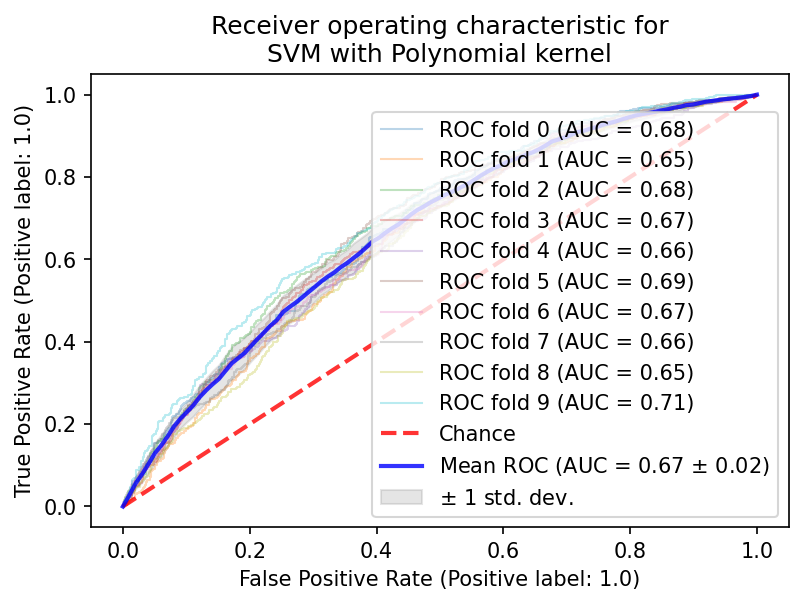

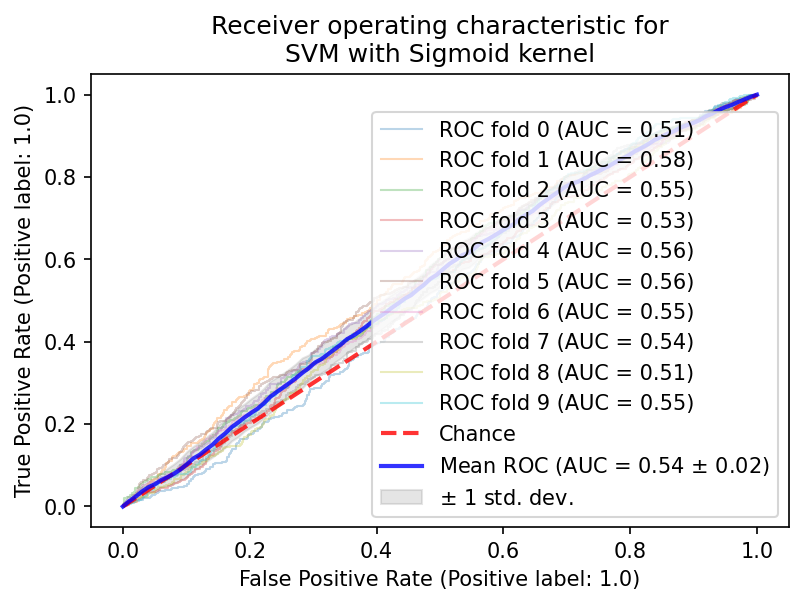

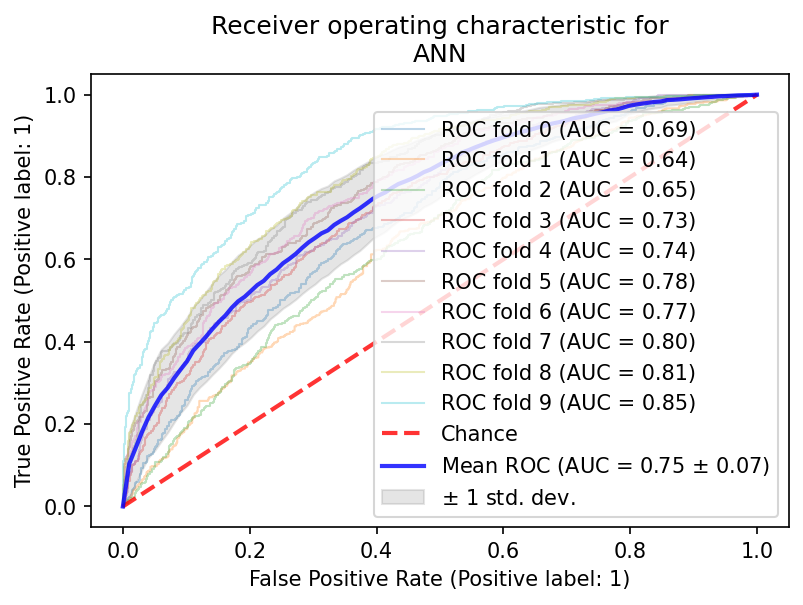

In [6]:
for name, cls in classifiers.items():
    plot_roc_KFold(cls, K=10, classifier_name=name)
